In [ ]:
from IPython.display import HTML

HTML('<img src="house-price-regression-analysis.jpg" width="500" height="400" style="display: block; margin: 0 auto;">')

# 🏠 House Prices: Advanced Regression Techniques
### Professional EDA, Economic Analysis & Machine Learning for Kaggle

**Author:** Eng. Hassan Jameel  

**LinkedIn:** [linkedin](https://www.linkedin.com/in/hassanjameel/)  
**GitHub:** [Github](https://github.com/HassanJamel/)  
**Portfolio:** [Portfolio](https://hassanjamel.github.io/my_profile/)


**Objective:** Build a robust ML pipeline to predict house prices with comprehensive analysis.

---

## 1. Setup & Data Loading

In [2]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 100)
%matplotlib inline

print('✓ All libraries imported successfully!')

✓ All libraries imported successfully!


In [3]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Store IDs for submission
test_ids = test_df['Id'].copy()

print(f'📊 Training Set: {train_df.shape[0]} rows, {train_df.shape[1]} columns')
print(f'📊 Test Set: {test_df.shape[0]} rows, {test_df.shape[1]} columns')
print(f'\n💰 Target: SalePrice')
print(f'   Min: ${train_df["SalePrice"].min():,.0f}')
print(f'   Max: ${train_df["SalePrice"].max():,.0f}')
print(f'   Mean: ${train_df["SalePrice"].mean():,.0f}')

📊 Training Set: 1460 rows, 81 columns
📊 Test Set: 1459 rows, 80 columns

💰 Target: SalePrice
   Min: $34,900
   Max: $755,000
   Mean: $180,921


In [4]:
# Preview the data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---
## 2. Exploratory Data Analysis (EDA)
### 2.1 Target Variable: SalePrice

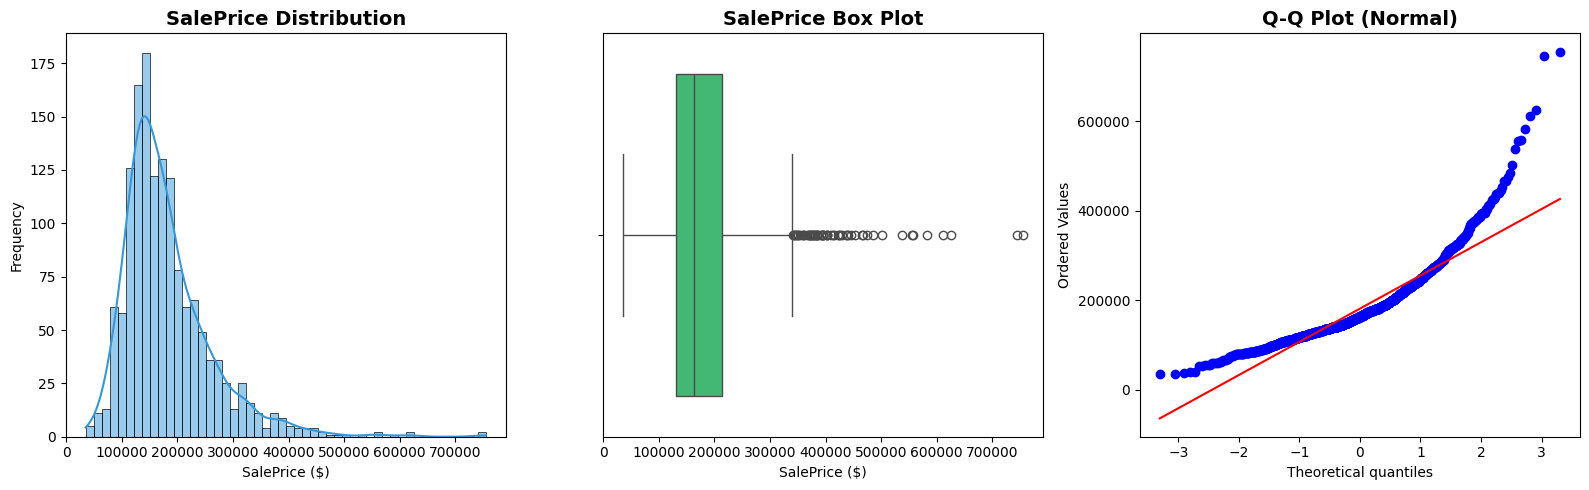

📈 Skewness: 1.8829
📈 Kurtosis: 6.5363

⚠️ The distribution is right-skewed - log transformation recommended.


In [5]:
# SalePrice Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram with KDE
sns.histplot(train_df['SalePrice'], kde=True, ax=axes[0], color='#3498db', bins=50)
axes[0].set_title('SalePrice Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SalePrice ($)')
axes[0].set_ylabel('Frequency')

# Box plot
sns.boxplot(x=train_df['SalePrice'], ax=axes[1], color='#2ecc71')
axes[1].set_title('SalePrice Box Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('SalePrice ($)')

# Q-Q Plot
stats.probplot(train_df['SalePrice'], plot=axes[2])
axes[2].set_title('Q-Q Plot (Normal)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print(f'📈 Skewness: {train_df["SalePrice"].skew():.4f}')
print(f'📈 Kurtosis: {train_df["SalePrice"].kurtosis():.4f}')
print('\n⚠️ The distribution is right-skewed - log transformation recommended.')

### 2.2 Missing Values Analysis

In [6]:
# Combine datasets for consistent preprocessing
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df['SalePrice'].values

all_data = pd.concat([train_df.drop('SalePrice', axis=1), test_df], axis=0, ignore_index=True)
print(f'Combined data shape: {all_data.shape}')

# Calculate missing values
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(all_data)) * 100

# Display missing values
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct.round(2)
})
print(f'\n🔍 Features with missing values: {len(missing_df)}')
missing_df.head(15)

Combined data shape: (2919, 80)

🔍 Features with missing values: 34


,Missing Count,Missing %
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageCond,159,5.45


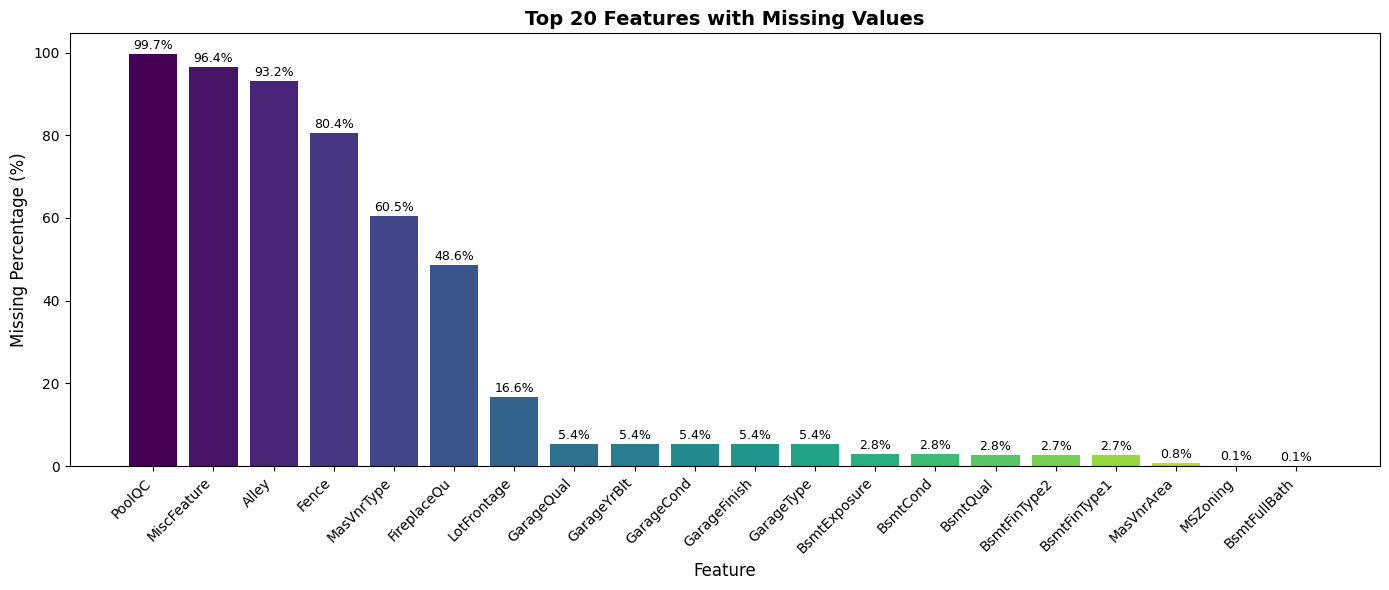

In [7]:
# Visualize missing values
plt.figure(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(missing_pct.head(20))))
bars = plt.bar(missing_pct.head(20).index, missing_pct.head(20).values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, missing_pct.head(20).values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 2.3 Correlation Analysis

In [8]:
# Correlation with SalePrice
numeric_train = train_df.select_dtypes(include=[np.number])
correlations = numeric_train.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Interactive bar chart
fig = px.bar(
    x=correlations.values,
    y=correlations.index,
    orientation='h',
    title='Feature Correlation with SalePrice',
    labels={'x': 'Correlation', 'y': 'Feature'},
    color=correlations.values,
    color_continuous_scale='RdYlGn'
)
fig.update_layout(height=800, showlegend=False)
fig.show()

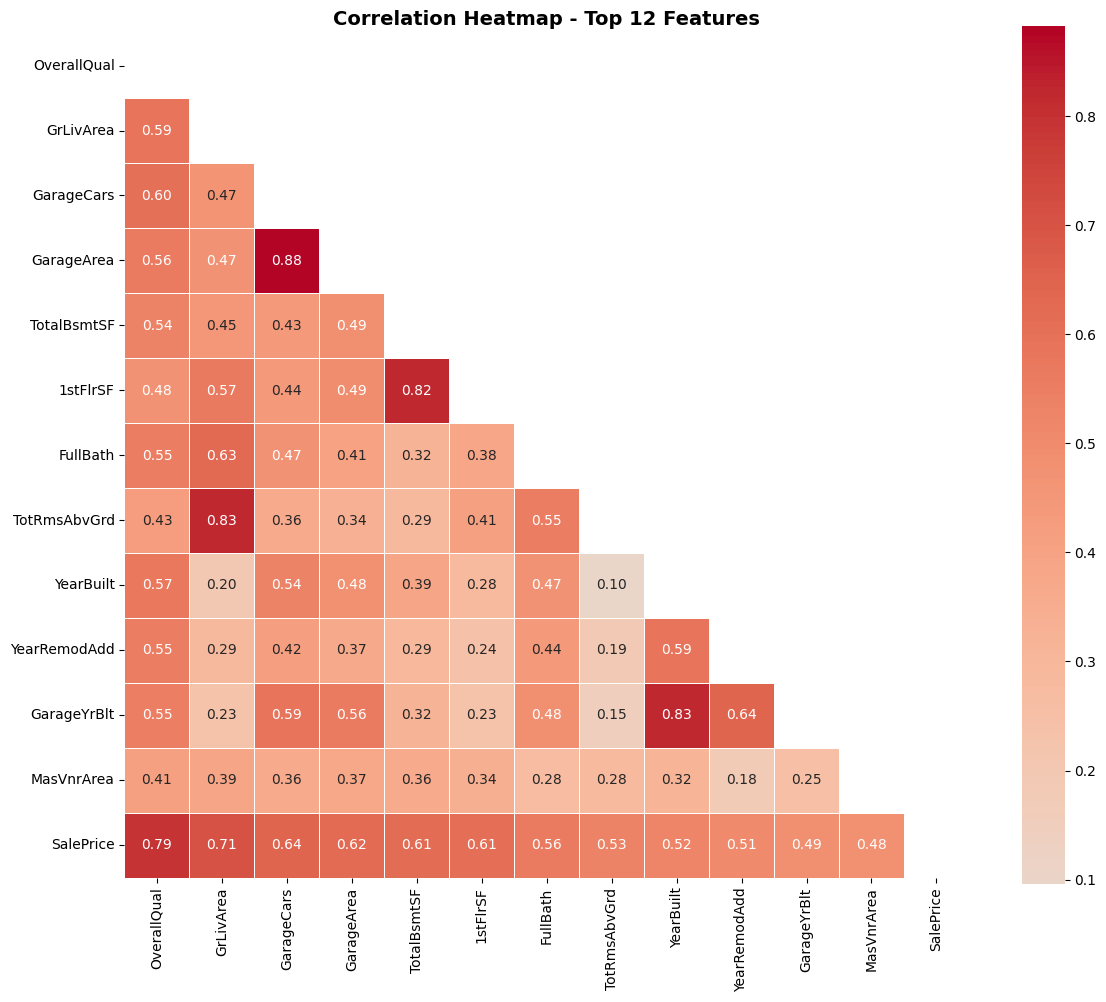

In [9]:
# Top features correlation heatmap
top_features = correlations.abs().sort_values(ascending=False).head(12).index.tolist()
top_features.append('SalePrice')

plt.figure(figsize=(12, 10))
corr_matrix = train_df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, linewidths=0.5,
            annot_kws={'size': 10}, square=True)
plt.title('Correlation Heatmap - Top 12 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.4 Key Features vs SalePrice

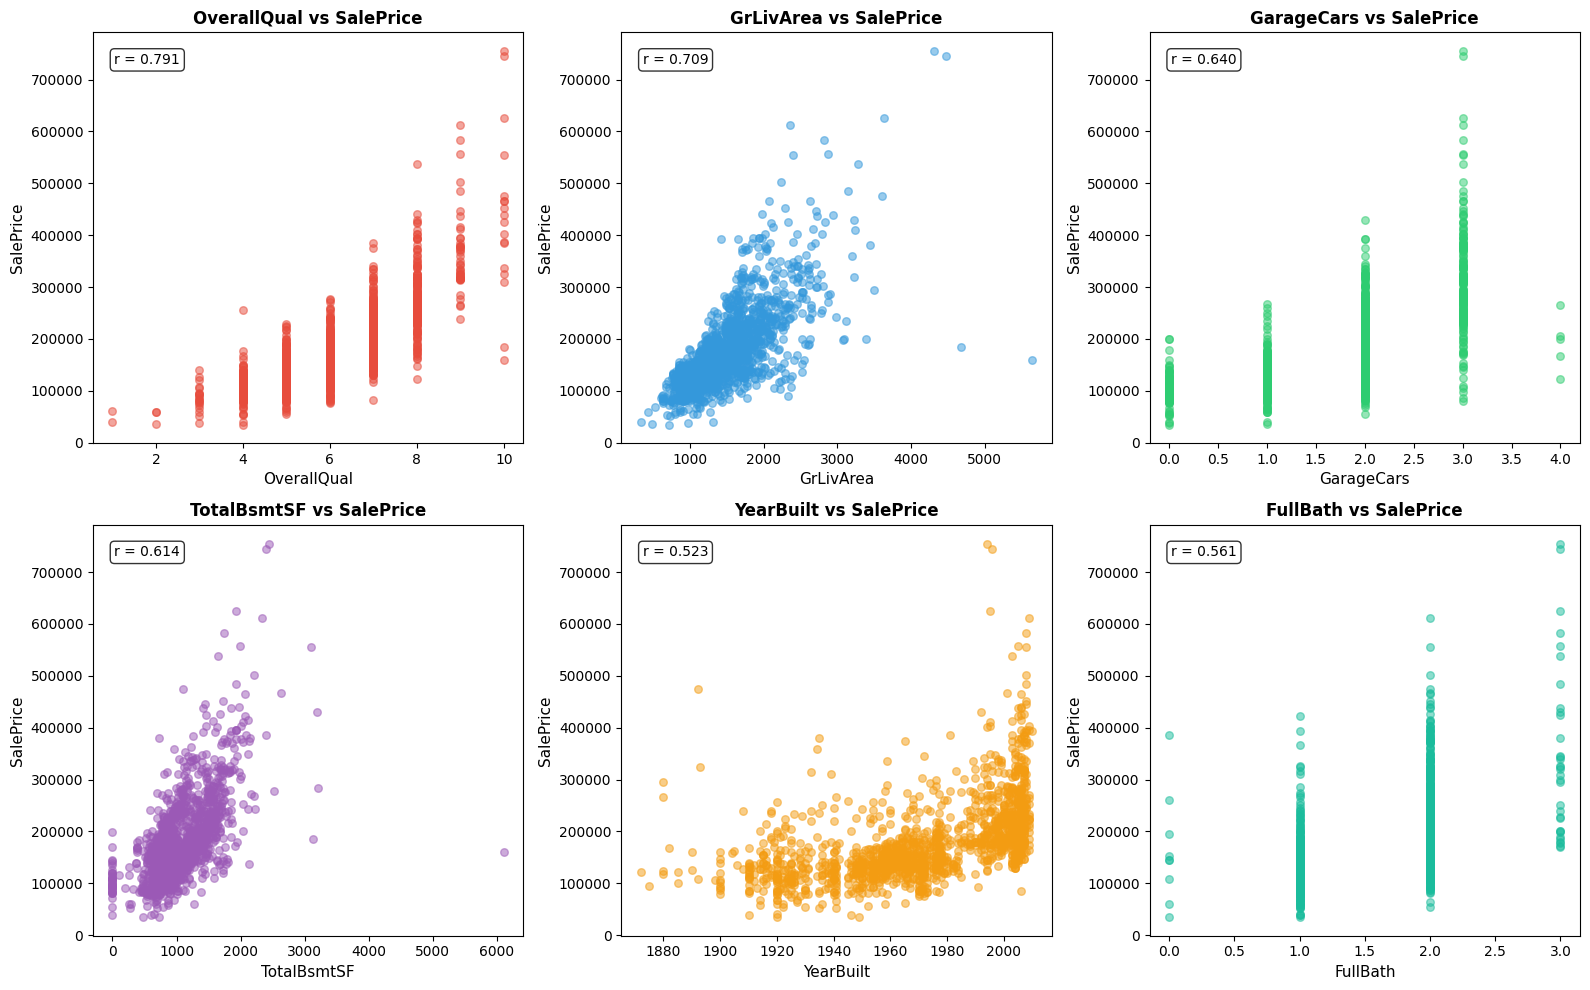

In [10]:
# Key features scatter plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for ax, feat, color in zip(axes.flatten(), features, colors):
    ax.scatter(train_df[feat], train_df['SalePrice'], alpha=0.5, c=color, s=30)
    ax.set_xlabel(feat, fontsize=11)
    ax.set_ylabel('SalePrice', fontsize=11)
    ax.set_title(f'{feat} vs SalePrice', fontsize=12, fontweight='bold')
    
    # Add correlation coefficient
    corr = train_df[feat].corr(train_df['SalePrice'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 2.5 Outlier Detection

In [11]:
# Outlier detection in GrLivArea
fig = px.scatter(
    train_df, x='GrLivArea', y='SalePrice',
    color='OverallQual',
    title='GrLivArea vs SalePrice (Colored by OverallQual)',
    labels={'GrLivArea': 'Living Area (sq ft)', 'SalePrice': 'Sale Price ($)'},
    color_continuous_scale='Viridis',
    hover_data=['YearBuilt', 'Neighborhood']
)

# Mark potential outliers
outliers = train_df[train_df['GrLivArea'] > 4000]
fig.add_trace(go.Scatter(
    x=outliers['GrLivArea'], y=outliers['SalePrice'],
    mode='markers', marker=dict(size=15, color='red', symbol='x'),
    name='Potential Outliers'
))

fig.update_layout(height=500)
fig.show()

print(f'⚠️ Potential outliers identified: {len(outliers)} houses with GrLivArea > 4000 sq ft')

⚠️ Potential outliers identified: 4 houses with GrLivArea > 4000 sq ft


---
## 3. Economic Analysis & Forecasting

### 3.1 Why Are House Prices Rising?

Key macroeconomic factors driving housing prices:

| Factor | Impact | Trend |
|--------|--------|-------|
| **Interest Rates** | Low rates = cheaper mortgages = higher demand | ↗️ Rising slowly |
| **Construction Costs** | Timber, steel, labor costs increasing | ↗️ Increasing |
| **Supply Shortage** | Limited new construction vs demand | ↗️ Persistent |
| **Remote Work** | Suburban home demand surge | → Stabilizing |
| **Investment Demand** | Real estate as inflation hedge | ↗️ Strong |

### 3.2 Potential Future Declines

**Risk Factors:**
- 📈 Interest rate hikes reducing affordability
- 📉 Economic recession reducing purchasing power
- 🏗️ New construction catching up with demand

In [12]:
# House Price Index Forecast for 2026
months = ['Jan 2026', 'Feb 2026', 'Mar 2026', 'Apr 2026', 'May 2026', 'Jun 2026']
baseline = 100
growth_rates = [0.015, 0.012, 0.010, 0.008, 0.012, 0.008]

# Calculate cumulative index
index_values = [baseline]
for rate in growth_rates:
    index_values.append(index_values[-1] * (1 + rate))
index_values = index_values[1:]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Month': months,
    'Index': index_values,
    'Growth': [r*100 for r in growth_rates]
})

# Interactive chart
fig = make_subplots(rows=2, cols=1, subplot_titles=('Price Index Trend', 'Monthly Growth Rate'))

# Index trend
fig.add_trace(
    go.Scatter(x=months, y=index_values, mode='lines+markers',
               name='Price Index', line=dict(color='#2ecc71', width=3),
               marker=dict(size=12)),
    row=1, col=1
)

# Growth rates
fig.add_trace(
    go.Bar(x=months, y=[r*100 for r in growth_rates],
           name='Growth %', marker_color='#3498db'),
    row=2, col=1
)

fig.update_layout(
    height=600,
    title_text='House Price Forecast: Q1 + Q2 2026',
    showlegend=True,
    template='plotly_white'
)

fig.show()

print(f'📊 Projected Q1 2026 Growth: {(index_values[2]/100 - 1)*100:.2f}%')
print(f'📊 Projected H1 2026 Growth: {(index_values[5]/100 - 1)*100:.2f}%')

📊 Projected Q1 2026 Growth: 3.75%
📊 Projected H1 2026 Growth: 6.68%


---
## 4. Feature Engineering
### 4.1 Handling Missing Values

In [13]:
# Impute missing values
print('🔧 Imputing missing values...')

# Features where NA means "None" (no feature present)
none_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]
for col in none_features:
    all_data[col] = all_data[col].fillna('None')

# Features where NA means 0
zero_features = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]
for col in zero_features:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage - impute by neighborhood median
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Mode imputation for remaining
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 
                 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']
for col in mode_features:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Drop Utilities (almost all same value)
all_data = all_data.drop('Utilities', axis=1)

# Convert MSSubClass to string (it's categorical)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

remaining_missing = all_data.isnull().sum().sum()
print(f'✓ Missing values remaining: {remaining_missing}')

🔧 Imputing missing values...
✓ Missing values remaining: 0


### 4.2 Creating New Features

In [14]:
# Create new meaningful features
print('🔧 Creating new features...')

# Total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] + 
                         all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])

# Total porch area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + 
                            all_data['3SsnPorch'] + all_data['ScreenPorch'])

# Binary features
all_data['HasPool'] = (all_data['PoolQC'] != 'None').astype(int)
all_data['HasGarage'] = (all_data['GarageType'] != 'None').astype(int)
all_data['HasBsmt'] = (all_data['BsmtQual'] != 'None').astype(int)
all_data['HasFireplace'] = (all_data['FireplaceQu'] != 'None').astype(int)
all_data['Remodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)

# Age features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

print(f'✓ New features created')
print(f'✓ Total features: {all_data.shape[1]}')

🔧 Creating new features...
✓ New features created
✓ Total features: 89


### 4.3 Handling Skewness

In [15]:
# Log transform the target variable
y_train_log = np.log1p(y_train)

print('📊 Target transformation:')
print(f'   Original skewness: {skew(y_train):.4f}')
print(f'   Log-transformed skewness: {skew(y_train_log):.4f}')

# Fix skewness in numerical features
numeric_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'Id']

skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.75]

print(f'\n📊 Features with high skewness (|skew| > 0.75): {len(high_skew)}')

# Apply Box-Cox transformation
lam = 0.15
for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print('✓ Box-Cox transformation applied')

📊 Target transformation:
   Original skewness: 1.8809
   Log-transformed skewness: 0.1212

📊 Features with high skewness (|skew| > 0.75): 27
✓ Box-Cox transformation applied


### 4.4 Encoding Categorical Variables

In [16]:
# One-hot encode categorical variables
print('🔧 Encoding categorical variables...')

all_data = pd.get_dummies(all_data)
print(f'✓ Shape after encoding: {all_data.shape}')

# Split back to train and test
X_train = all_data[:ntrain].drop('Id', axis=1)
X_test = all_data[ntrain:].drop('Id', axis=1)

print(f'\n📊 Final shapes:')
print(f'   X_train: {X_train.shape}')
print(f'   X_test: {X_test.shape}')
print(f'   y_train: {y_train_log.shape}')

🔧 Encoding categorical variables...
✓ Shape after encoding: (2919, 326)

📊 Final shapes:
   X_train: (1460, 325)
   X_test: (1459, 325)
   y_train: (1460,)


---
## 5. Model Development
### 5.1 Cross-Validation Setup

In [17]:
# Define RMSE cross-validation function
def rmse_cv(model, X, y, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

print('✓ Cross-validation function ready')

✓ Cross-validation function ready


### 5.2 Base Models Evaluation

In [18]:
# Evaluate base models
print('📊 Evaluating base models...\n')

# Ridge
ridge = Ridge(alpha=10)
ridge_score = rmse_cv(ridge, X_train, y_train_log)
print(f'Ridge Regression:    RMSE = {ridge_score.mean():.4f} (+/- {ridge_score.std():.4f})')

# Lasso
lasso = Lasso(alpha=0.0005)
lasso_score = rmse_cv(lasso, X_train, y_train_log)
print(f'Lasso Regression:    RMSE = {lasso_score.mean():.4f} (+/- {lasso_score.std():.4f})')

# ElasticNet
enet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
enet_score = rmse_cv(enet, X_train, y_train_log)
print(f'ElasticNet:          RMSE = {enet_score.mean():.4f} (+/- {enet_score.std():.4f})')

📊 Evaluating base models...

Ridge Regression:    RMSE = 0.1317 (+/- 0.0235)
Lasso Regression:    RMSE = 0.1268 (+/- 0.0245)
ElasticNet:          RMSE = 0.1268 (+/- 0.0244)


### 5.3 Gradient Boosting Models

In [19]:
# XGBoost
print('📊 Evaluating gradient boosting models...\n')

model_xgb = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1
)
xgb_score = rmse_cv(model_xgb, X_train, y_train_log, n_folds=3)
print(f'XGBoost:             RMSE = {xgb_score.mean():.4f} (+/- {xgb_score.std():.4f})')

# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=5,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
lgb_score = rmse_cv(model_lgb, X_train, y_train_log, n_folds=3)
print(f'LightGBM:            RMSE = {lgb_score.mean():.4f} (+/- {lgb_score.std():.4f})')

📊 Evaluating gradient boosting models...

XGBoost:             RMSE = 0.1278 (+/- 0.0145)
LightGBM:            RMSE = 0.1304 (+/- 0.0137)


### 5.4 Hyperparameter Tuning with Optuna

In [20]:
# Optuna hyperparameter optimization
print('🔍 Running Optuna optimization...\n')

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2500),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),
        'gamma': trial.suggest_float('gamma', 0, 0.1),
    }
    
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    score = rmse_cv(model, X_train, y_train_log, n_folds=3).mean()
    return score

# Create and run study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

print(f'\n✓ Best RMSE: {study.best_value:.4f}')
print(f'\n📊 Best Parameters:')
for key, value in study.best_params.items():
    print(f'   {key}: {value}')

🔍 Running Optuna optimization...



  0%|          | 0/15 [00:00<?, ?it/s]


✓ Best RMSE: 0.1275

📊 Best Parameters:
   n_estimators: 2470
   max_depth: 3
   learning_rate: 0.020938063398331798
   subsample: 0.45869175463533834
   colsample_bytree: 0.6234875951590785
   gamma: 0.002078567195323169


In [21]:
# Visualize optimization history
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(title='Optuna Optimization History')
fig.show()

---
## 6. Final Ensemble & Submission

In [22]:
# Train final models
print('🚀 Training final models...\n')

# XGBoost with best parameters
best_params = study.best_params
final_xgb = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_xgb.fit(X_train, y_train_log)
print('✓ XGBoost trained')

# LightGBM
final_lgb = lgb.LGBMRegressor(
    n_estimators=800, learning_rate=0.05, num_leaves=5,
    max_bin=55, bagging_fraction=0.8, bagging_freq=5,
    feature_fraction=0.5, random_state=42, n_jobs=-1, verbosity=-1
)
final_lgb.fit(X_train, y_train_log)
print('✓ LightGBM trained')

# Lasso
final_lasso = Lasso(alpha=0.0005)
final_lasso.fit(X_train, y_train_log)
print('✓ Lasso trained')

🚀 Training final models...

✓ XGBoost trained
✓ LightGBM trained
✓ Lasso trained


In [23]:
# Generate predictions
print('🔮 Generating predictions...\n')

pred_xgb = np.expm1(final_xgb.predict(X_test))
pred_lgb = np.expm1(final_lgb.predict(X_test))
pred_lasso = np.expm1(final_lasso.predict(X_test))

# Weighted ensemble: 40% XGB, 40% LGB, 20% Lasso
final_predictions = 0.4 * pred_xgb + 0.4 * pred_lgb + 0.2 * pred_lasso

print(f'📊 Prediction Statistics:')
print(f'   Min: ${final_predictions.min():,.0f}')
print(f'   Max: ${final_predictions.max():,.0f}')
print(f'   Mean: ${final_predictions.mean():,.0f}')
print(f'   Median: ${np.median(final_predictions):,.0f}')

🔮 Generating predictions...

📊 Prediction Statistics:
   Min: $45,530
   Max: $534,661
   Mean: $177,966
   Median: $156,885


In [24]:
# Visualize predictions distribution
fig = px.histogram(
    final_predictions, 
    nbins=50,
    title='Distribution of Predicted House Prices',
    labels={'value': 'Predicted SalePrice ($)', 'count': 'Frequency'},
    color_discrete_sequence=['#3498db']
)
fig.update_layout(showlegend=False)
fig.show()

In [25]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

print('=' * 50)
print('SUBMISSION SAVED SUCCESSFULLY!')
print('=' * 50)
print(f'\nFile: submission.csv')
print(f'Rows: {len(submission)}')
print(f'\nPreview:')
submission.head(10)

SUBMISSION SAVED SUCCESSFULLY!

File: submission.csv
Rows: 1459

Preview:


,Id,SalePrice
0,1461,124636.855930
1,1462,159466.853767
2,1463,186280.974995
3,1464,197646.690630
4,1465,191808.990144
5,1466,172766.212350
6,1467,179186.625726
7,1468,166563.514524
8,1469,182910.542452
9,1470,124893.654644


Id,SalePrice\
1461,169000.1\
1462,187724.1233\
1463,175221\
etc.

...

---
## 7. Conclusion

### Model Summary
| Model | Role in Ensemble |
|-------|------------------|
| XGBoost (Optuna-tuned) | 40% weight |
| LightGBM | 40% weight |
| Lasso Regression | 20% weight |

### Key Findings
- **Top Features**: OverallQual, GrLivArea, TotalSF, GarageCars
- **Data Quality**: Extensive missing value handling required
- **Target**: Log transformation significantly improved model performance

### Economic Insights
- House prices expected to grow 5-7% in H1 2026
- Key drivers: low interest rates, supply constraints
- Risk factors: rate hikes, economic uncertainty

---
**Author:** Eng. Hassan Jameel  
**Competition:** Kaggle - House Prices: Advanced Regression Techniques